In [1]:
# Environment requires netam-experiments-1's shmex, netam, and epam.
import matplotlib.pyplot as plt
from shmex.shm_data import pcp_df_of_non_shmoof_nickname
from netam.multihit import (
    MultihitBurrito,
    train_test_datasets_of_pcp_df,
    HitClassModel,
    prepare_pcp_df,
)
from epam import oe_plot
from netam.pretrained import load
import torch
import pandas as pd
import pickle

In [2]:
# Some plotting functions

def make_hc_site_df(hit_class_burrito):
    adjustments = torch.cat([torch.tensor([0.0]), hit_class_burrito.model.values]).exp()
    train_data = hit_class_burrito.train_dataset
    df_rows = []
    for seq_idx, (observed_hcs, hc_probs_l, codon_mask) in enumerate(zip(train_data.observed_hcs, train_data.hit_class_probs, train_data.codon_mask)):
        observed_hcs = observed_hcs[codon_mask]

        hc_probs = hc_probs_l[codon_mask]
        for site, (hc, hc_probs) in enumerate(zip(observed_hcs, hc_probs)):
            adjusted_probs = hc_probs * adjustments
            adjusted_probs = torch.clamp(adjusted_probs, min=torch.finfo(adjusted_probs.dtype).eps)
            adjusted_probs = (adjusted_probs / adjusted_probs.sum()).detach().numpy()
            df_rows.append((seq_idx, site, hc, adjusted_probs[0], adjusted_probs[1], adjusted_probs[2], adjusted_probs[3]))

    return pd.DataFrame(
        df_rows,
        columns=[
            "sequence",
            "site",
            "hit_class",
            "0_hc_prob",
            "1_hc_prob",
            "2_hc_prob",
            "3_hc_prob",
        ]
    )

def oe_plot_of_hc_site_df(hc_site_df):
    fig, axs = plt.subplots(3, 1, figsize=(12, 20))

    for i in range(3):
        hit_class = i + 1
        plot_df = pd.DataFrame({
            "mutation": hc_site_df["hit_class"] == hit_class,
            "prob": hc_site_df[f"{hit_class}_hc_prob"].clip(lower=torch.finfo(torch.float64).eps),
        })
        
        result_dict = oe_plot.plot_observed_vs_expected(plot_df, None, axs[i], None)
        axs[i].set_title(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
    fig.tight_layout()
    return fig

First we'll load the data and the existing crepe for the model that we're going to adjust:

In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    # "l2_regularization_coeff": 1e-6
}
epochs = 200
site_count = 500

neutral_name = "ThriftyHumV0.2-59"
crepe = load(neutral_name)
output_crepe_path = f"../train/{neutral_name}-hc"
output_branch_lengths_path = output_crepe_path + "-branch-lengths"

model = HitClassModel()

tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
# subsampled_tang_df = tang_df.iloc[::int(len(tang_df)/500)].copy().reset_index(drop=True)
# print(len(subsampled_tang_df))
subsampled_tang_df = tang_df.copy().reset_index(drop=True)
pcp_df = prepare_pcp_df(subsampled_tang_df, crepe, site_count)

val_data, train_data = train_test_datasets_of_pcp_df(pcp_df, train_frac=0.8)
# starting_branch_lengths_estimates = train_data.branch_lengths
# We want to use all the data for training here, so we mis-use the function to give us only one dataset.
# _, train_data = train_test_datasets_of_pcp_df(pcp_df, train_frac=0.0)
# val_data = train_data
starting_branch_lengths_estimates = torch.concat([train_data.branch_lengths, val_data.branch_lengths])

Using cached models: /home/wdumm/dnsm-netam-proj/netam/netam/_pretrained/thrifty-0.2.0.zip
Loading /home/wdumm/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz
Loaded 7000 PCPs from tangshm


## Branch Length Optimization
`train_data` and `val_data` are `HitClassDataset`s, which contain the data from the crepe loaded above necessary to compute uncorrected codon probabilities. `MultihitBurrito.find_optimal_branch_lengths` optimizes branch lengths using those codon probabilities, corrected using the hit class weights in `burrito.model`.

In [4]:
burrito = MultihitBurrito(train_data, val_data, model, **burrito_params)

In [5]:

burrito.standardize_and_optimize_branch_lengths()
new_branch_lengths = torch.concat([burrito.train_dataset.branch_lengths, burrito.val_dataset.branch_lengths])
branch_lengths_without_hc_adjustment = new_branch_lengths.clone()
# val_data.branch_lengths = burrito.find_optimal_branch_lengths(val_data)

Optimizing branch lengths:   0%|          | 15/5598 [00:01<07:31, 12.38it/s]/home/wdumm/dnsm-netam-proj/netam/netam/molevol.py:659: UserWarning: Optimization failed with invalid bracket. Trying bounded method
  warn("Optimization failed with invalid bracket. Trying bounded method")
/home/wdumm/dnsm-netam-proj/netam/netam/molevol.py:673: UserWarning: Optimization result is near lower threshold. This may indicate a problem.
  warn(
Optimizing branch lengths: 100%|██████████| 1400/1400 [02:50<00:00,  8.23it/s]


In [6]:
# Model parameters start at 0 (they're log hit class factors)
burrito.model.values.exp()

tensor([1., 1., 1.], grad_fn=<ExpBackward0>)

Just want to check that the branch length estimates look similar to the initial branch length approximation, which is fraction of sites mutated in each pcp:

Text(0, 0.5, 'fitted value')

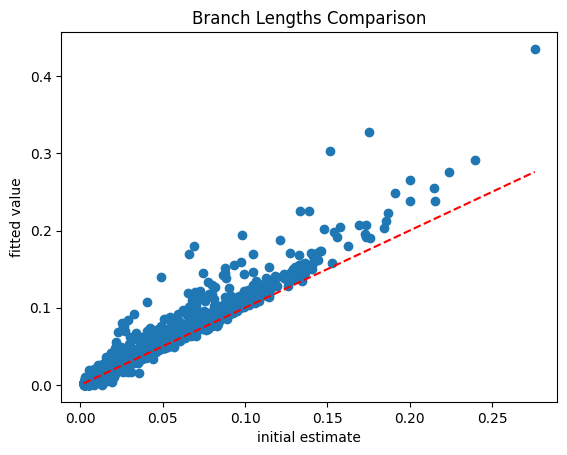

In [7]:
fig, ax = plt.subplots()

ax.scatter(starting_branch_lengths_estimates, branch_lengths_without_hc_adjustment)
xmin, xmax = min(starting_branch_lengths_estimates), max(starting_branch_lengths_estimates)
ax.plot([xmin, xmax], [xmin, xmax], color='red', linestyle='--', label='y=x')

ax.set_title('Branch Lengths Comparison')

ax.set_xlabel('initial estimate')
ax.set_ylabel('fitted value')

## Model Training
Before training the model, we'll have a look at the hit-class faceted OE plots for the uncorrected model:

tensor([1., 1., 1.], grad_fn=<ExpBackward0>)
loss 38128.55859375


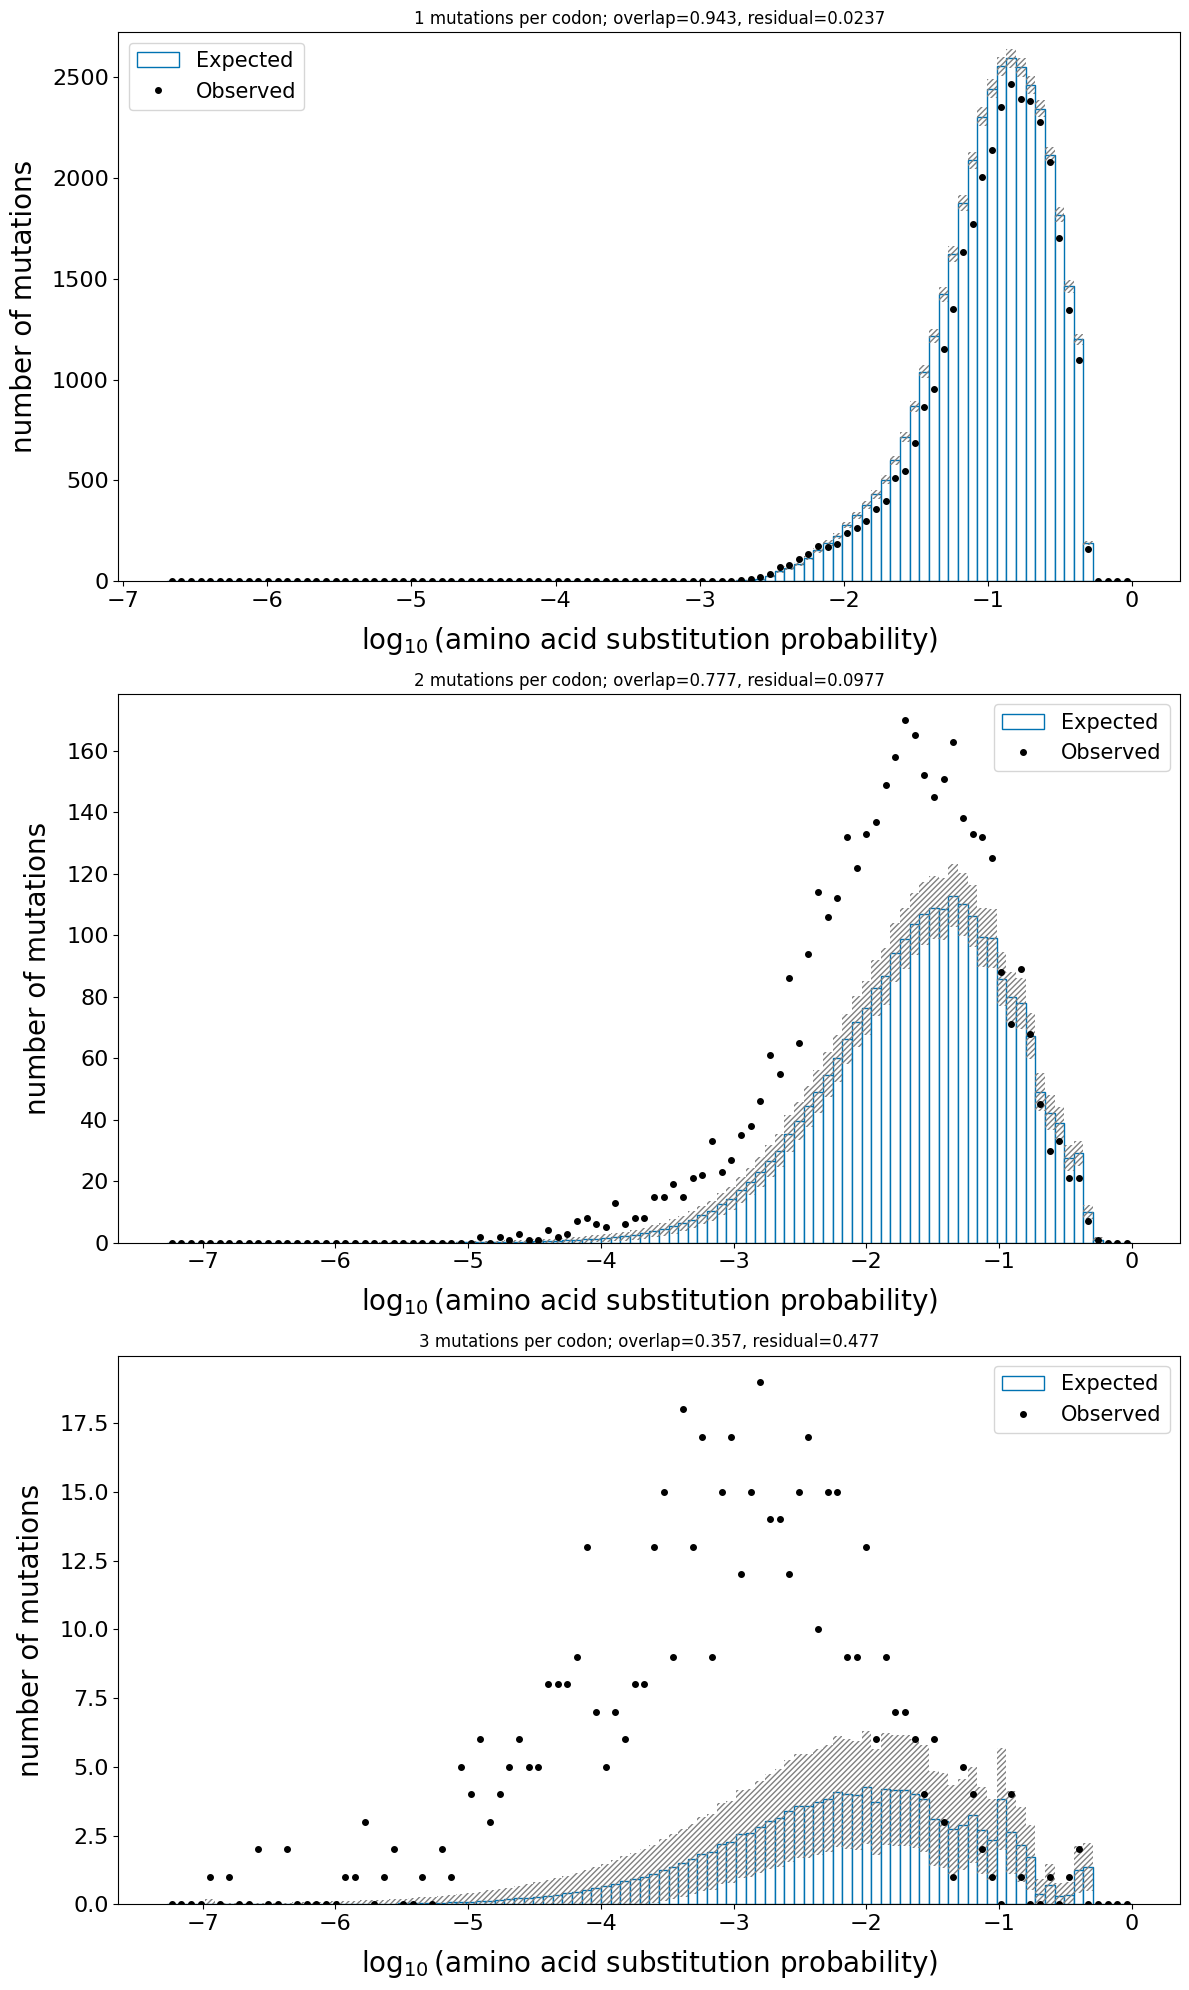

In [8]:
# Let's have a look at the oe plots before fitting model parameters (so adjustments do nothing):
print(burrito.model.values.exp())
train_loader = burrito.build_train_loader()
print("loss", burrito.process_data_loader(train_loader, train_mode=False).item())
hc_site_df = make_hc_site_df(burrito)
fig = oe_plot_of_hc_site_df(hc_site_df)

...And now we can train:

In [9]:
burrito.model.reinitialize_weights()
burrito.reset_optimization()
# # This is much faster, but doesn't re-optimize branch lengths after training the model parameters:
# train_history = burrito.multi_train(epochs=epochs, max_tries=5)

# We already optimized branch lengths so no need to do it again...
train_history = burrito.joint_train(epochs=epochs, optimize_bl_first_cycle=False)

### Beginning cycle 1/2 using optimizer RMSprop


Optimizing branch lengths:   0%|          | 10/5598 [00:00<00:57, 97.30it/s]/home/wdumm/dnsm-netam-proj/netam/netam/molevol.py:659: UserWarning: Optimization failed with invalid bracket. Trying bounded method
  warn("Optimization failed with invalid bracket. Trying bounded method")
/home/wdumm/dnsm-netam-proj/netam/netam/molevol.py:673: UserWarning: Optimization result is near lower threshold. This may indicate a problem.
  warn(
Optimizing branch lengths: 100%|██████████| 1400/1400 [01:09<00:00, 20.17it/s]


### Beginning cycle 2/2 using optimizer RMSprop


Optimizing branch lengths:  79%|███████▊  | 4397/5598 [03:35<00:26, 45.74it/s] /home/wdumm/dnsm-netam-proj/netam/netam/molevol.py:582: UserWarning: Bracket failed. Trying again.
  warn("Bracket failed. Trying again.")
Optimizing branch lengths: 100%|██████████| 1400/1400 [01:43<00:00, 13.46it/s]


Now we can re-build the OE plots to see how we did:

In [10]:
burrito.model.values.exp()

tensor([0.8499, 1.0716, 1.6613], grad_fn=<ExpBackward0>)

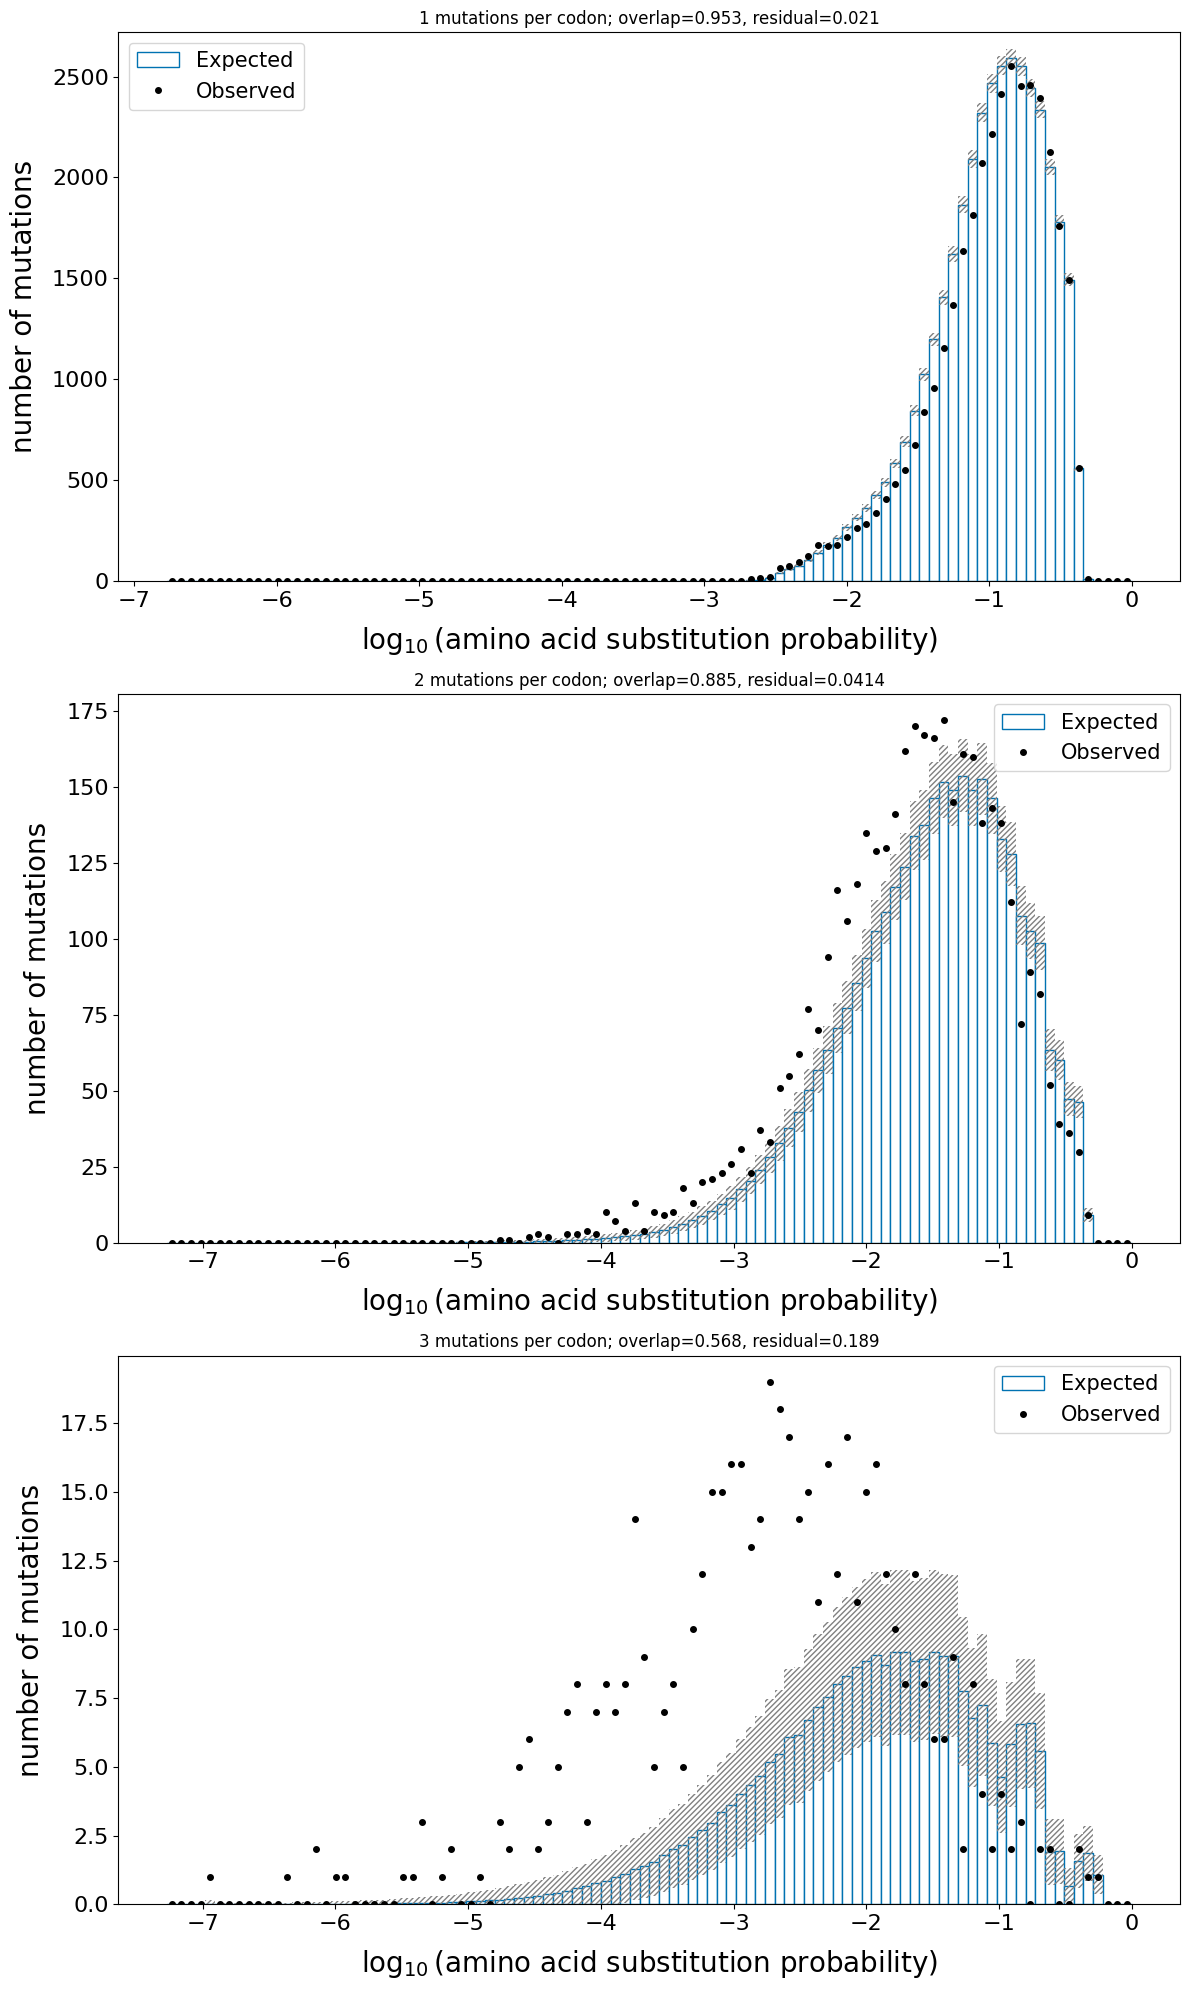

In [11]:
hc_site_df = make_hc_site_df(burrito)
fig = oe_plot_of_hc_site_df(hc_site_df)

I was curious about branch lengths before and after the correction, compared to the initial estimates:

Text(0, 0.5, 'hc adjusted fitted value')

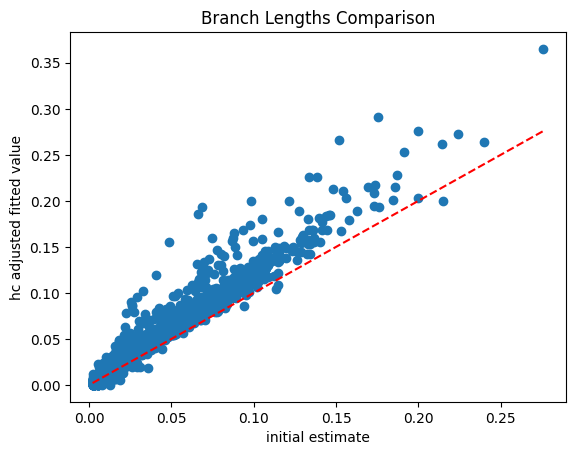

In [12]:
fig, ax = plt.subplots()

hc_adjusted_branch_lengths = torch.concat([burrito.train_dataset.branch_lengths, burrito.val_dataset.branch_lengths])
ax.scatter(starting_branch_lengths_estimates, hc_adjusted_branch_lengths)
xmin, xmax = min(starting_branch_lengths_estimates), max(starting_branch_lengths_estimates)
ax.plot([xmin, xmax], [xmin, xmax], color='red', linestyle='--', label='y=x')

ax.set_title('Branch Lengths Comparison')

ax.set_xlabel('initial estimate')
ax.set_ylabel('hc adjusted fitted value')

Text(0, 0.5, 'fitted value with hc adjustment')

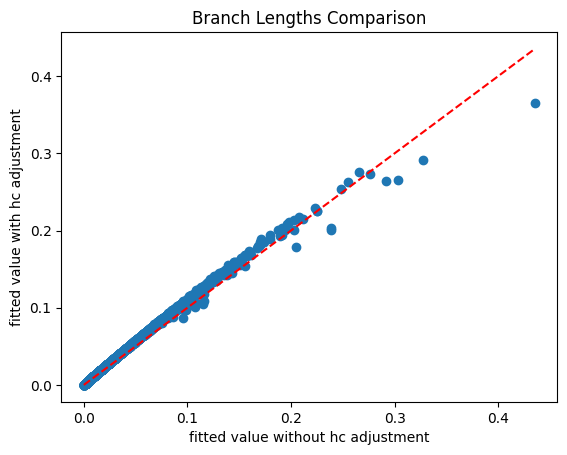

In [13]:

fig, ax = plt.subplots()

ax.scatter(branch_lengths_without_hc_adjustment, hc_adjusted_branch_lengths)
xmin, xmax = min(branch_lengths_without_hc_adjustment), max(branch_lengths_without_hc_adjustment)
ax.plot([xmin, xmax], [xmin, xmax], color='red', linestyle='--', label='y=x')

ax.set_title('Branch Lengths Comparison')

ax.set_xlabel('fitted value without hc adjustment')
ax.set_ylabel('fitted value with hc adjustment')

In [14]:
# Save the model
burrito.save_crepe(output_crepe_path)
with open(output_branch_lengths_path, 'wb') as fh:
    pickle.dump(train_data.branch_lengths, fh)